(1)选择测试图像（Lena灰度图或其它），添加高斯噪声（低，中高水平）

(512, 512)


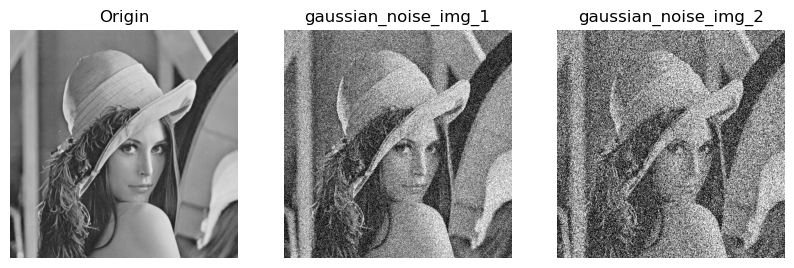

In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

img = cv2.imread("luna.png", 0)
print(img.shape)


#添加高斯噪声
variance = 2500 #设置方差
gaussian = np.random.normal(0, np.sqrt(variance), img.shape)  #第一个参数为0时就代表高斯分布
gaussian_noise_img1 = np.clip(img + gaussian, 0, 255).astype(np.uint8)

#添加更高程度的高斯噪声
variance = 10000
gaussian = np.random.normal(0, np.sqrt(variance), img.shape)
gaussian_noise_img2 = np.clip(img + gaussian, 0, 255).astype(np.uint8)

#可视化
fig, ax = plt.subplots(1, 3, figsize=(10,7))
ax[0].imshow(img, "gray", vmin=0, vmax=255)
ax[0].set_title('Origin')
ax[0].axis('off')
ax[1].imshow(gaussian_noise_img1, "gray", vmin=0, vmax=255)
ax[1].set_title('gaussian_noise_img_1')
ax[1].axis('off')
ax[2].imshow(gaussian_noise_img2, "gray", vmin=0, vmax=255)
ax[2].set_title('gaussian_noise_img_2')
ax[2].axis('off')
plt.show()

(2)运用下列几种方式去噪:

(2.1)高斯低通

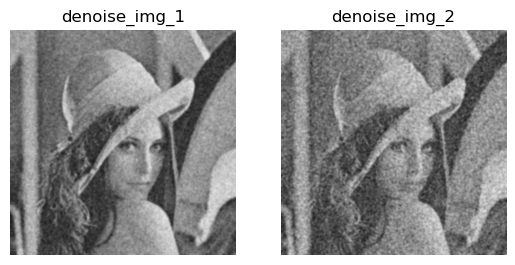

In [2]:
denoise_img_1 = cv2.GaussianBlur(gaussian_noise_img1, (9, 9), 0)
denoise_img_2 = cv2.GaussianBlur(gaussian_noise_img2, (9, 9), 0)

plt.subplot(121)
plt.imshow(denoise_img_1, "gray", vmin=0, vmax=255)
plt.title('denoise_img_1')
plt.axis('off')
plt.subplot(122)
plt.imshow(denoise_img_2, "gray", vmin=0, vmax=255)
plt.title('denoise_img_2')
plt.axis('off')
plt.show()

(2.2)小波去噪

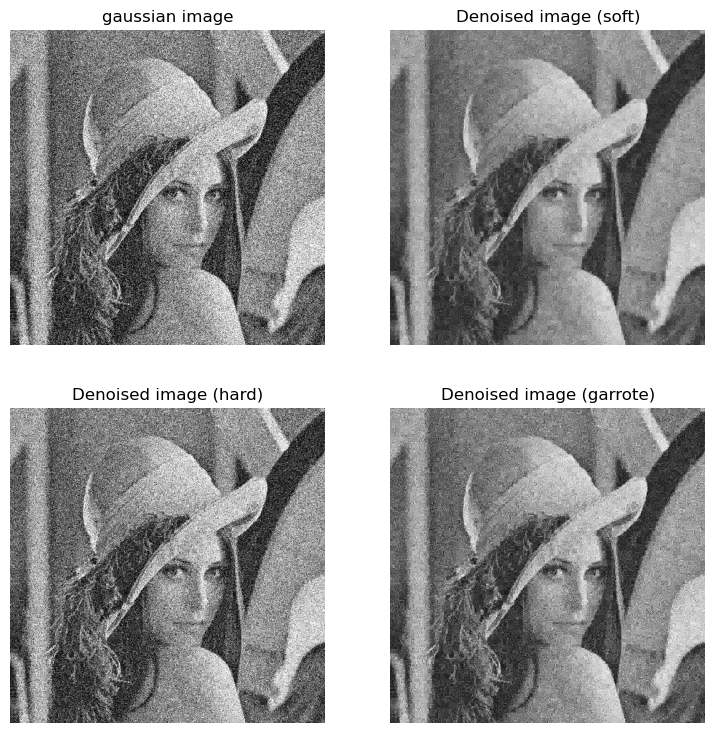

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pywt

# 进行小波阈值去噪函数
def wavelet_denoise_2d(image, wavelet='db4', level=1, mode='soft', threshold_rule='universal'):
    # 进行二维小波分解(多级)
    coeffs = pywt.wavedec2(image, wavelet, level=level)    #关于wavelet参数，看这个https://pywavelets.readthedocs.io/en/latest/ref/wavelets.html#wavelet-families
    # 根据规则选择合适的阈值
    if threshold_rule == 'universal':
        sigma = np.median(np.abs(coeffs[-1])) / 0.6745
    elif threshold_rule == 'mad':
        sigma = 1.4826 * np.median(np.abs(coeffs[-1] - np.median(coeffs[-1])))
    else:
        raise ValueError("Invalid threshold_rule: {}".format(threshold_rule))
    # 对各层系数进行阈值处理
    coeffs_list = list(coeffs)
    for i in range(1, len(coeffs_list)):
        coeffs_list[i] = tuple(pywt.threshold(coeff, value=sigma, mode=mode) for coeff in coeffs_list[i])  #value指阈值
    coeffs = tuple(coeffs_list)
    # 进行二维小波重构
    denoised_image = pywt.waverec2(coeffs, wavelet)
    return denoised_image

# 进行小波阈值去噪
denoised_img_soft = wavelet_denoise_2d(gaussian_noise_img1, wavelet='haar', mode='soft',level=3)
denoised_img_hard = wavelet_denoise_2d(gaussian_noise_img1, wavelet='haar', mode='hard',level=3)
denoised_img_garrote = wavelet_denoise_2d(gaussian_noise_img1, wavelet='haar', mode='garrote',level=3)  #garrote就是指半软半硬阈值处理

# 绘制图像
plt.figure(figsize=(9, 9))
plt.subplot(2, 2, 1)
plt.imshow(gaussian_noise_img1, cmap='gray', vmin=0, vmax=255)
plt.title('gaussian image')
plt.axis('off')
plt.subplot(2, 2, 2)
plt.imshow(denoised_img_soft, cmap='gray', vmin=0, vmax=255)
plt.title('Denoised image (soft)')
plt.axis('off')
plt.subplot(2, 2, 3)
plt.imshow(denoised_img_hard, cmap='gray', vmin=0, vmax=255)
plt.title('Denoised image (hard)')
plt.axis('off')
plt.subplot(2, 2, 4)
plt.imshow(denoised_img_garrote, cmap='gray', vmin=0, vmax=255)
plt.title('Denoised image (garrote)')
plt.axis('off')
plt.show()


从上图中看出，软阈值方法得到的图像比较平滑，噪声减少的比较多，优于硬阈值方法，而介于它们中间的半软半硬阈值方法处理效果最好。

(2.3)双边滤波去噪

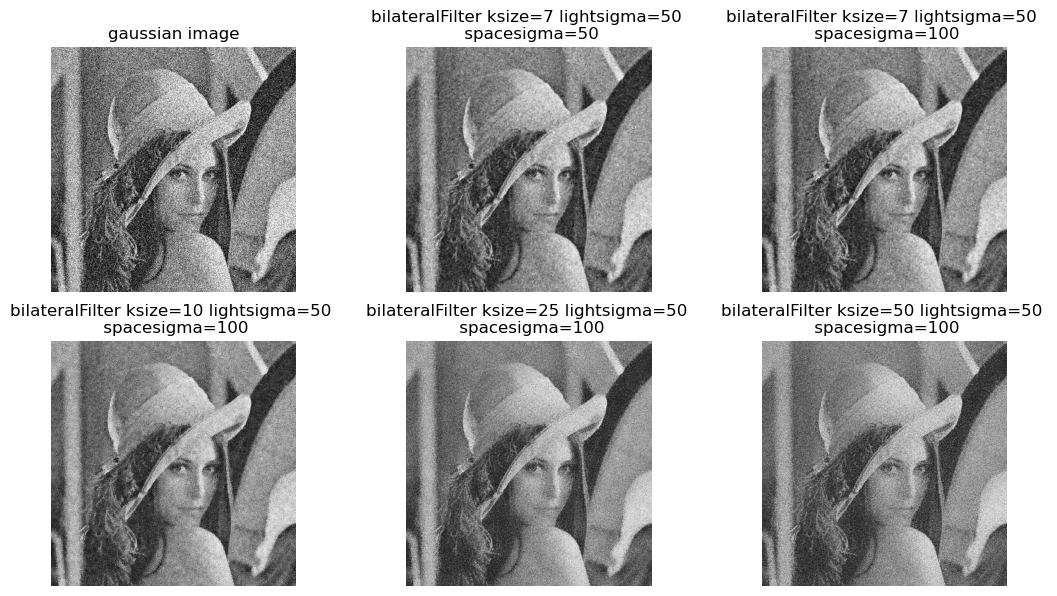

In [4]:
bilat_1 = cv2.bilateralFilter(gaussian_noise_img1, 7, 50, 50)  #后三个参数分别是窗口大小，亮度差的sigma参数，空间距离的sigma参数
bilat_2 = cv2.bilateralFilter(gaussian_noise_img1, 7, 50, 100)
bilat_3 = cv2.bilateralFilter(gaussian_noise_img1, 10, 50, 100)
bilat_4 = cv2.bilateralFilter(gaussian_noise_img1, 25, 50, 100)
bilat_5 = cv2.bilateralFilter(gaussian_noise_img1, 50, 50, 100)
# 绘制图像
plt.figure(figsize=(13, 7))
plt.subplot(2, 3, 1)
plt.imshow(gaussian_noise_img1, cmap='gray', vmin=0, vmax=255)
plt.title('gaussian image')
plt.axis('off')
plt.subplot(2, 3, 2)
plt.imshow(bilat_1, cmap='gray', vmin=0, vmax=255)
plt.title('bilateralFilter ksize=7 lightsigma=50 \n spacesigma=50')
plt.axis('off')
plt.subplot(2, 3, 3)
plt.imshow(bilat_2, cmap='gray', vmin=0, vmax=255)
plt.title('bilateralFilter ksize=7 lightsigma=50 \n spacesigma=100')
plt.axis('off')
plt.subplot(2, 3, 4)
plt.imshow(bilat_3, cmap='gray', vmin=0, vmax=255)
plt.title('bilateralFilter ksize=10 lightsigma=50 \n spacesigma=100')
plt.axis('off')
plt.subplot(2, 3, 5)
plt.imshow(bilat_4, cmap='gray', vmin=0, vmax=255)
plt.title('bilateralFilter ksize=25 lightsigma=50 \n spacesigma=100')
plt.axis('off')
plt.subplot(2, 3, 6)
plt.imshow(bilat_5, cmap='gray', vmin=0, vmax=255)
plt.title('bilateralFilter ksize=50 lightsigma=50 \n spacesigma=100')
plt.axis('off')
plt.show()

像素邻域的直径越大，去噪效果越明显。

(2.4)非局部均值

255 0


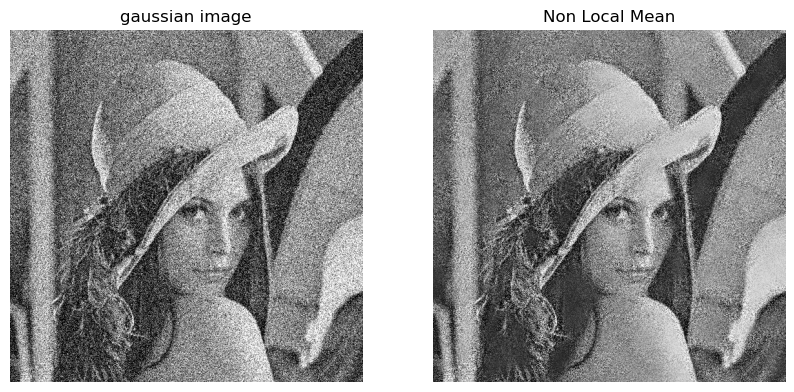

In [14]:
nl = cv2.fastNlMeansDenoising(gaussian_noise_img1, 10, 27, 21)

print(np.max(nl-gaussian_noise_img1), np.min(nl-gaussian_noise_img1))
# 绘制图像
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(gaussian_noise_img1, cmap='gray', vmin=0, vmax=255)
plt.title('gaussian image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(nl, cmap='gray', vmin=0, vmax=255)
plt.title('Non Local Mean')
plt.axis('off')
plt.show()

去噪效果不是很好